# Quadratic Assignment Problem

In [1]:
import sys

import docplex

from docplex.mp.model import Model 

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import time

In [2]:
#Instance Random generation 

np.random.seed(1)


def create_test(L, W):
    Departments = range(L*W)
    x = np.zeros(L*W)
    y = np.zeros(L*W)

    n = 0
    for i, w in enumerate(range(W)):
        for j, l in enumerate(range(L)):
            x[n] = i   
            y[n] = j
            n += 1
    Dist = np.zeros((n,n),dtype=int)

    for i in Departments:
        for j in Departments:
            Dist[i,j] = np.absolute(x[i]-x[j]) + np.absolute(y[i]-y[j])


    Flow = np.random.randint(low = 10, high = 20, size =(L*W,L*W), dtype=int) 

    return Flow, Dist


def function(dists, flow, solution):
    n = len(dists)
    res = 0
    for i in range(n):
        for j in range(n):
            res += dists[i][j] * flow[solution[i]][solution[j]]
    return res

Formulation below needs testing.

In [3]:
def real_solve(Dist, Flow):
    Departments = range(len(Dist))
    QAP = Model('Quadratic Assignment Problem')

    w = QAP.continuous_var_dict(((i,j,k,l) 
                            for i in Departments
                            for j in Departments
                            for k in Departments
                            for l in Departments), name = 'w')

    x =  QAP.binary_var_matrix(Departments, Departments, name = 'x')

    QAP.minimize(QAP.sum(Flow[i,k]*Dist[j,l]*w[i,j,k,l] 
                         for i in Departments 
                         for j in Departments
                         for k in Departments 
                         for l in Departments))

    QAP.add_constraints(QAP.sum(x[i,j] for i in Departments) == 1 
                        for j in Departments)

    QAP.add_constraints(QAP.sum(x[i,j] for j in Departments) == 1 
                        for i in Departments)

    QAP.add_constraints(QAP.sum(w[i,j,k,l] for i in Departments) == x[k,l] 
                        for j in Departments 
                        for k in Departments 
                        for l in Departments)

    QAP.add_constraints(QAP.sum(w[i,j,k,l] for j in Departments) == x[k,l] 
                        for i in Departments 
                        for k in Departments 
                        for l in Departments)

    QAP.add_constraints((w[i,j,k,l]) == w[k,l,i,j] 
                        for i in Departments 
                        for j in Departments
                        for k in Departments 
                        for l in Departments)

    QAP.context.solver.log_output = True
    QAP.context.solver.verbose = 5

    QAP.solve()

    print('OFV:',QAP.objective_value,'\n')

    solution = [0] * len(Departments)
    for i in Departments:
        for j in Departments:
            if QAP.solution.get_value(x[i,j]):
#                 print('Dept', i, '@', j)
                solution[j] = i
    return function(Dist, Flow, solution)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 136 rows and 0 columns.
Aggregator did 120 substitutions.
Reduced MIP has 136 rows, 152 columns, and 672 nonzeros.
Reduced MIP has 16 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.63 ticks)
Found incumbent of value 240.000000 after 0.00 sec. (0.83 ticks)
Probing fixed 0 vars, tightened 48 bounds.
Probing time = 0.00 sec. (0.16 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 32 rows and 64 columns.
Reduced MIP has 104 rows, 88 columns, and 416 nonzeros.
Reduced MIP has 16 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.18 ticks)
Probing time = 0.00 sec. (0.12 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 104 rows, 88 columns, and 416 nonzeros.
Reduced MIP has 16 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.37

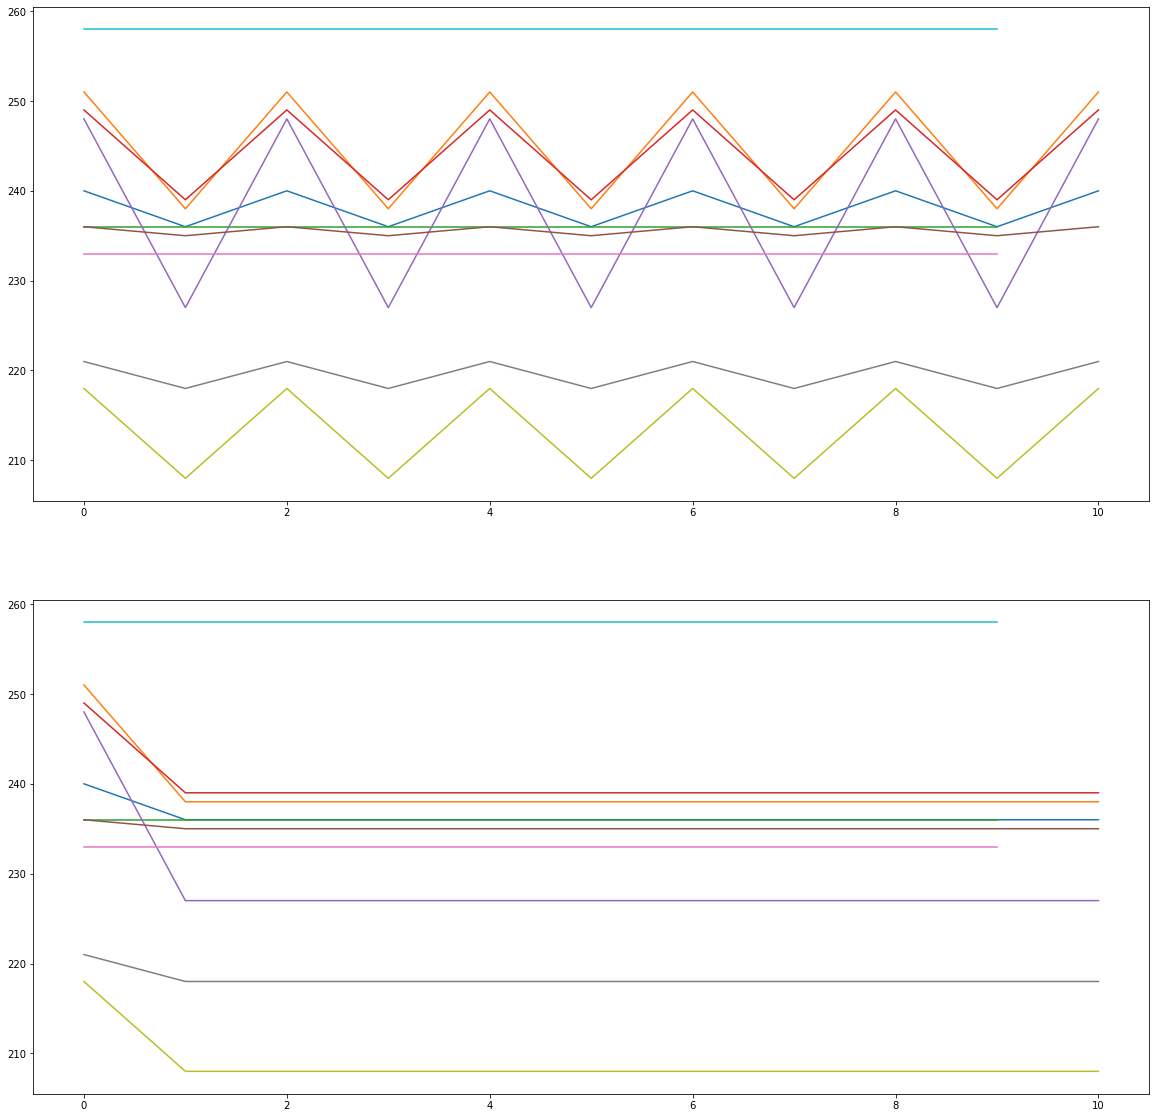

In [4]:
from collections import deque

def vertex_func(dists, flow, solution, v):
    res = 0
    for i in range(len(solution)):
        res += flow[solution[v]][solution[i]] * dists[v][i]
        res += flow[solution[i]][solution[v]] * dists[i][v]
    return res
        
def solve(dists, flows, memory_steps):
    tabu = deque()
    n = len(dists)
    results = []
    best_results = []
    
    # solution[i] = j ~ department j at place i
    solution = list(range(n))
    best_solution = solution.copy()
    best_function = function(dists, flows, best_solution)
    
    best_neigh = solution
    best_neigh_func = best_function
    
    best_not_changed_steps = 0
    
    while best_not_changed_steps < 10:
        solution = best_neigh
        solution_func = best_neigh_func
        best_neigh_func = np.Inf
        best_results.append(best_function)
        results.append(solution_func)
        swaped = ()
        best_not_changed_steps += 1
        for i in range(len(solution)):
            for j in range(i + 1, len(solution)):
                if solution[i] in tabu or solution[j] in tabu:
                    continue
                old_weight = vertex_func(dists, flows, solution, i) + \
                                vertex_func(dists, flows, solution, j)
                solution[i], solution[j] = solution[j], solution[i]
                new_weight = vertex_func(dists, flows, solution, i) + \
                                vertex_func(dists, flows, solution, j)
                new_function = solution_func + new_weight - old_weight
                if new_function < best_neigh_func:
                    best_neigh_swap = (i, j)
                    best_neigh_func = new_function
                    swaped = (solution[i], solution[j])
                    
                if new_function < best_function:
                    best_solution = solution.copy()
                    best_function = new_function
                    best_not_changed_steps = 0
                
                solution[i], solution[j] = solution[j], solution[i]
        i, j = best_neigh_swap
        solution[i], solution[j] = solution[j], solution[i]
        tabu.append(swaped[0])
        tabu.append(swaped[1])
        if (len(tabu) > memory_steps * 2):
            tabu.popleft()
            tabu.popleft()
#         print(tabu, best_function, swaped)
    return best_function, results, best_results

        
def func_test(fig, size, iters):
    _, (fig1, fig2) = fig.subplots(2, 1, figsize=(20, 20))
    real_results = []
    search_results = []
    for i in range(iters):
        dists, flow = create_test(*size)
        real = real_solve(dists, flow)
#         real, results, best_results = solve(dists, flow, 1)
        tabu_s_result, results, best_results = solve(dists, flow, 1)
        fig1.plot(results)
        fig2.plot(best_results)
        
        real_results.append(real)
        search_results.append(tabu_s_result)
    return real_results, search_results
        
real, search = func_test(plt, (2, 2), 10)

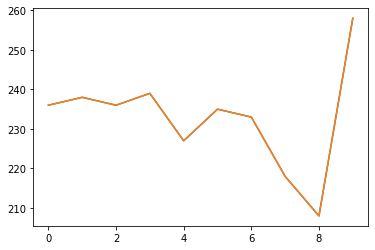

In [5]:
plt.plot(real)
plt.plot(search)

0.008071660995483398
0.09682512283325195
1.085261344909668
2.7628557682037354
16.73963689804077


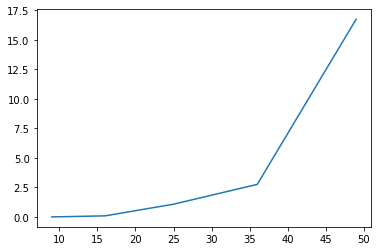

In [6]:
def time_test(size):
    dists, flow = create_test(*size)
    beg = time.time()
    tabu_s_result, results, best_results = solve(dists, flow, size[0])
    end = time.time()
    return end - beg, results, best_results

xs = [3, 4, 5, 6, 7]
times = []
history = []
for x in xs:
    t, *hist = time_test((x, x))
    print(t)
    times.append(t)
    history.append(hist)
plt.plot([x * x for x in xs], times)

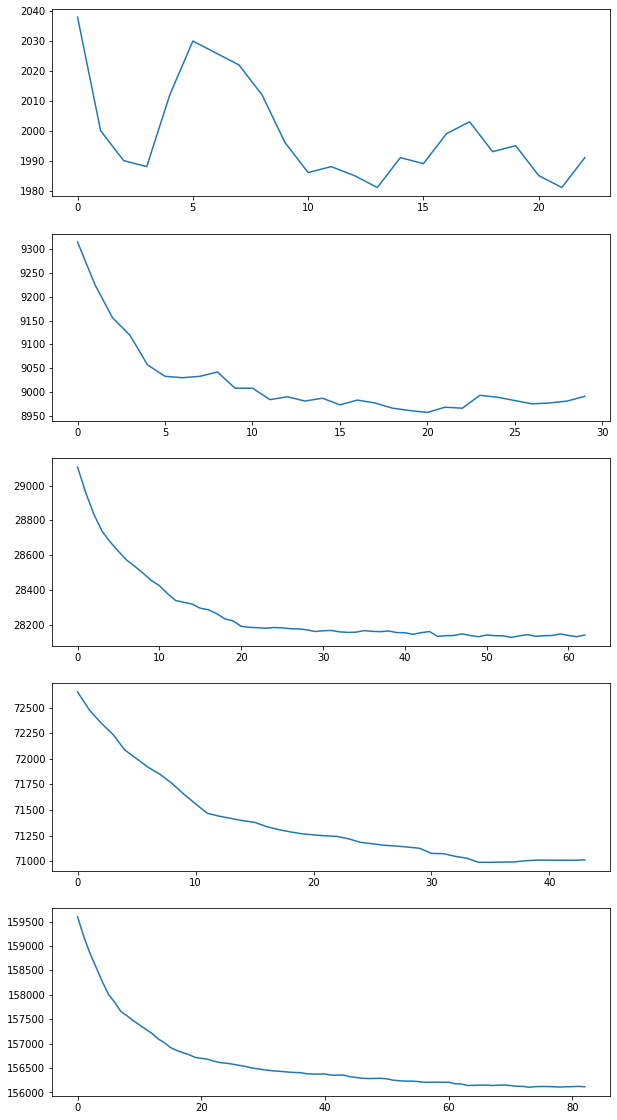

In [7]:
fig, plots = plt.subplots(len(history), 1, figsize=(10, 20))

for plot, hist in zip(plots, history):
    plot.plot(hist[0])